In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "emopain_svm"

data_types = ["emg", "energy", "angle"]
encoders = ["STL-V", "STL-S", "rate", "latency"]

data = []
filenames = []
for data_type in data_types:
    for encoder in encoders:
        # Exception for bsz results for STL-S [32, 8, 16]
        # if encoder == "STL-V":
        #     results = pd.read_csv(f'../results/{file}_bsz/results_{data_type}_{encoder}.csv', index_col=0)
        # else:
        results = pd.read_csv(f'../results/{file}/results_{data_type}_{encoder}.csv', index_col=0)
        filenames.append(f"{file} {data_type} {encoder}")
        print(filenames[-1])
        results.set_index('fold', inplace=True)
        results.index = results.index.astype(int)
        # deduplicate the fold index
        results = results[~results.index.duplicated(keep='first')]
        results['test_preds'] = results['test_preds'].apply(lambda x: int(x.strip('[]')))
        results['test_labels'] = results['test_labels'].apply(lambda x: int(x.strip('[]')))
        print(f'{data_type}_{encoder}: {results.shape}')
        results.sort_index()
        
        data.append(results)

data[0].tail()

emopain_svm emg STL-V
emg_STL-V: (46, 6)
emopain_svm emg STL-S
emg_STL-S: (46, 6)
emopain_svm emg rate
emg_rate: (46, 6)
emopain_svm emg latency
emg_latency: (46, 6)
emopain_svm energy STL-V
energy_STL-V: (46, 6)
emopain_svm energy STL-S
energy_STL-S: (46, 6)
emopain_svm energy rate
energy_rate: (46, 6)
emopain_svm energy latency
energy_latency: (46, 6)
emopain_svm angle STL-V
angle_STL-V: (46, 6)
emopain_svm angle STL-S
angle_STL-S: (46, 6)
emopain_svm angle rate
angle_rate: (46, 6)
emopain_svm angle latency
angle_latency: (46, 6)


,train_acc,val_acc,test_acc,test_preds,test_labels,sparsity
fold,,,,,,
43,-1,-1,100.0,0,0,0.006280
44,-1,-1,0.0,1,0,0.006488
45,-1,-1,0.0,0,1,0.003107
0,-1,-1,100.0,0,0,0.003925
1,-1,-1,100.0,0,0,0.006737


In [23]:

results_dict = {}
for i, d in enumerate(data):
    file, data_type, encoder = filenames[i].split(" ")
    filename = f"{file}_{data_type}_{encoder}"
    print(file, data_type, encoder)

    accuracies = d["test_acc"]
    sparsities = d["sparsity"]
    preds = d["test_preds"].to_numpy().flatten()
    labels = d["test_labels"].to_numpy().flatten()
    print(np.mean(accuracies))
    print(np.mean(sparsities))
    
    try:
        results_dict[filename]["accuracies"].append(np.mean(accuracies))
        results_dict[filename]["sparsities"].append(np.mean(sparsities))
        results_dict[filename]["labels"].append(labels)
        results_dict[filename]["preds"].append(preds)
    except:
        results_dict[filename] = {"accuracies": [np.mean(accuracies)],
                                  "sparsities": [np.mean(sparsities)],
                                  "preds": [preds],
                                  "labels": [labels]}


emopain_svm emg STL-V
71.73913043478261
0.007335253623188375
emopain_svm emg STL-S
32.608695652173914
0.37549663043478254
emopain_svm emg rate
65.21739130434783
0.06816956521739127
emopain_svm emg latency
67.3913043478261
0.09999999999999995
emopain_svm energy STL-V
56.52173913043478
0.4388046135265701
emopain_svm energy STL-S
43.47826086956522
0.6964393961352656
emopain_svm energy rate
63.04347826086956
0.5835318719806764
emopain_svm energy latency
73.91304347826087
0.09999999999999995
emopain_svm angle STL-V
58.69565217391305
0.5276824758454106
emopain_svm angle STL-S
47.82608695652174
0.7925291062801934
emopain_svm angle rate
54.34782608695652
0.7028106642512076
emopain_svm angle latency
67.3913043478261
0.09999999999999995


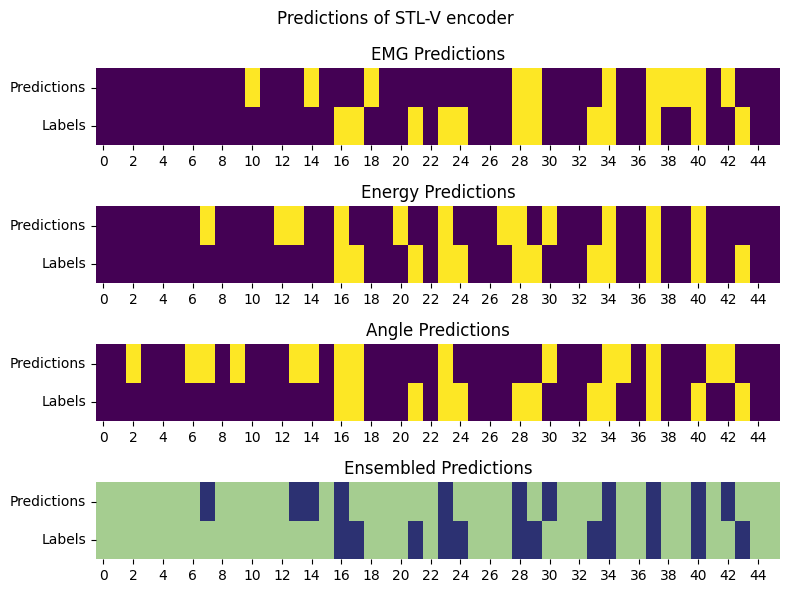

Ensemble Accuracy: 0.7608695652173914
Ensemble AUC: 0.676470588235294
Ensemble F1 Score: 0.5217391304347826 <- 0.55 & 0.50
Ensemble MCC: 0.3633306583585879
Harmonic mean sparsity: 0.021352019027161454 <- 0.007 & 0.439 & 0.528


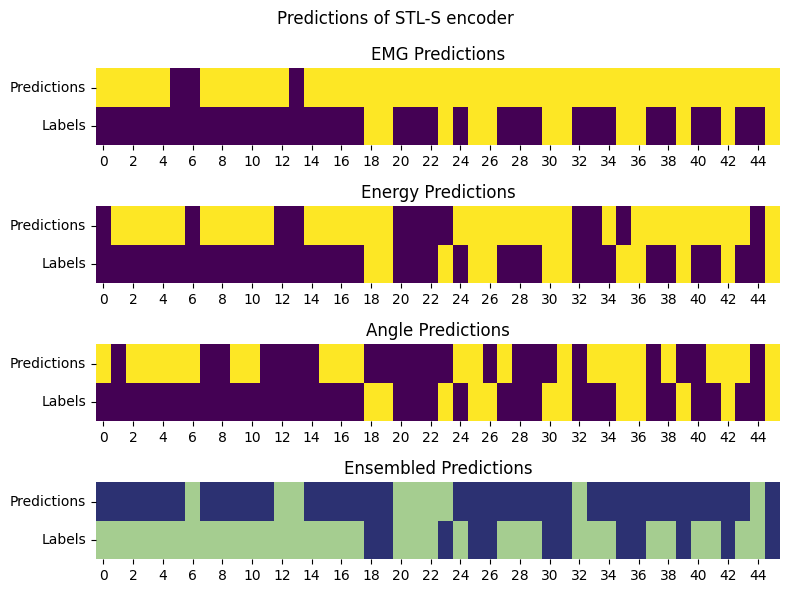

Ensemble Accuracy: 0.41304347826086957
Ensemble AUC: 0.5759803921568627
Ensemble F1 Score: 0.4489795918367347 <- 0.30 & 0.92
Ensemble MCC: 0.16820522845986144
Harmonic mean sparsity: 0.5596181582463781 <- 0.375 & 0.696 & 0.793


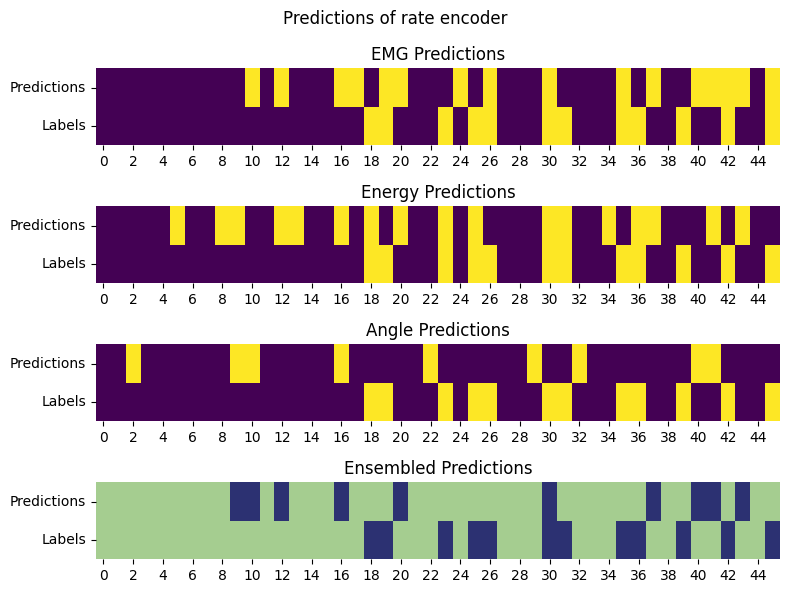

Ensemble Accuracy: 0.5652173913043478
Ensemble AUC: 0.4093137254901961
Ensemble F1 Score: 0.0909090909090909 <- 0.10 & 0.08
Ensemble MCC: -0.19308582308458774
Harmonic mean sparsity: 0.1684838240522863 <- 0.068 & 0.584 & 0.703


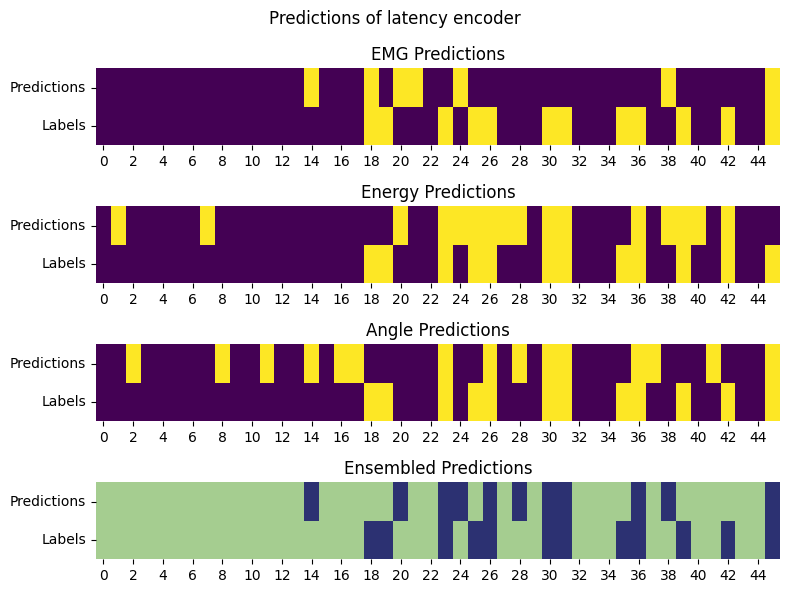

Ensemble Accuracy: 0.7608695652173914
Ensemble AUC: 0.676470588235294
Ensemble F1 Score: 0.5217391304347826 <- 0.55 & 0.50
Ensemble MCC: 0.3633306583585879
Harmonic mean sparsity: 0.09999999999999995 <- 0.100 & 0.100 & 0.100


In [24]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef
from scipy.stats import hmean

ensemble = {}

for encoder in encoders:
    # Extract predictions and labels
    emg_preds = results_dict[f'emopain_svm_emg_{encoder}']['preds'][0]
    energy_preds = results_dict[f'emopain_svm_energy_{encoder}']['preds'][0]
    angle_preds = results_dict[f'emopain_svm_angle_{encoder}']['preds'][0]
    labels = results_dict[f'emopain_svm_emg_{encoder}']['labels'][0]  # Assuming labels are the same for all data types

    # Calculate accuracy weights
    emg_acc = results_dict[f'emopain_svm_emg_{encoder}']['accuracies'][0]
    energy_acc = results_dict[f'emopain_svm_energy_{encoder}']['accuracies'][0]
    angle_acc = results_dict[f'emopain_svm_angle_{encoder}']['accuracies'][0]

    weights = [emg_acc, energy_acc, angle_acc]

    # Perform accuracy-weighted majority voting
    ensemble_preds = np.round(
        (emg_preds * weights[0] + energy_preds * weights[1] + angle_preds * weights[2]) / sum(weights)
    ).astype(int)

    fig, axs = plt.subplots(4, 1, figsize=(8,6))

    sns.heatmap(np.vstack([emg_preds, labels]), ax=axs[0], cbar=False, cmap='viridis')
    axs[0].set_title('EMG Predictions')
    axs[0].set_yticklabels(['Predictions', 'Labels'])
    axs[0].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([energy_preds, labels]), ax=axs[1], cbar=False, cmap='viridis')
    axs[1].set_title('Energy Predictions')
    axs[1].set_yticklabels(['Predictions', 'Labels'])
    axs[1].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([angle_preds, labels]), ax=axs[2], cbar=False, cmap='viridis')
    axs[2].set_title('Angle Predictions')
    axs[2].set_yticklabels(['Predictions', 'Labels'])
    axs[2].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([ensemble_preds, labels]), ax=axs[3], cbar=False, cmap='crest')
    axs[3].set_yticklabels(['Predictions', 'Labels'])
    axs[3].tick_params(axis='y', rotation=0)
    axs[3].set_title('Ensembled Predictions')

    plt.suptitle(f"Predictions of {encoder} encoder")
    plt.tight_layout()
    plt.show()

    
    # Calculate the harmonic mean sparsity
    sparsities = [
        results_dict[f'emopain_svm_emg_{encoder}']['sparsities'][0],
        results_dict[f'emopain_svm_energy_{encoder}']['sparsities'][0],
        results_dict[f'emopain_svm_angle_{encoder}']['sparsities'][0]
    ]

    harmonic_mean_sparsity = hmean(sparsities)

    # Calculate and print ensemble performance metrics
    ensemble_accuracy = accuracy_score(labels, ensemble_preds)
    ensemble_auc = roc_auc_score(labels, ensemble_preds)
    ensemble_f1 = f1_score(labels, ensemble_preds)
    ensemble_prec = precision_score(labels, ensemble_preds)
    ensemble_rec = recall_score(labels, ensemble_preds)
    ensemble_mcc = matthews_corrcoef(labels, ensemble_preds)

    print(f'Ensemble Accuracy: {ensemble_accuracy}')
    print(f'Ensemble AUC: {ensemble_auc}')
    print(f'Ensemble F1 Score: {ensemble_f1} <- {ensemble_prec:.2f} & {ensemble_rec:.2f}')
    print(f'Ensemble MCC: {ensemble_mcc}')
    print(f'Harmonic mean sparsity: {harmonic_mean_sparsity} <- {" & ".join([f"{s:.3f}" for s in sparsities])}')
    
    ensemble[encoder] = [ensemble_accuracy, ensemble_auc, ensemble_f1, ensemble_mcc, harmonic_mean_sparsity]
    


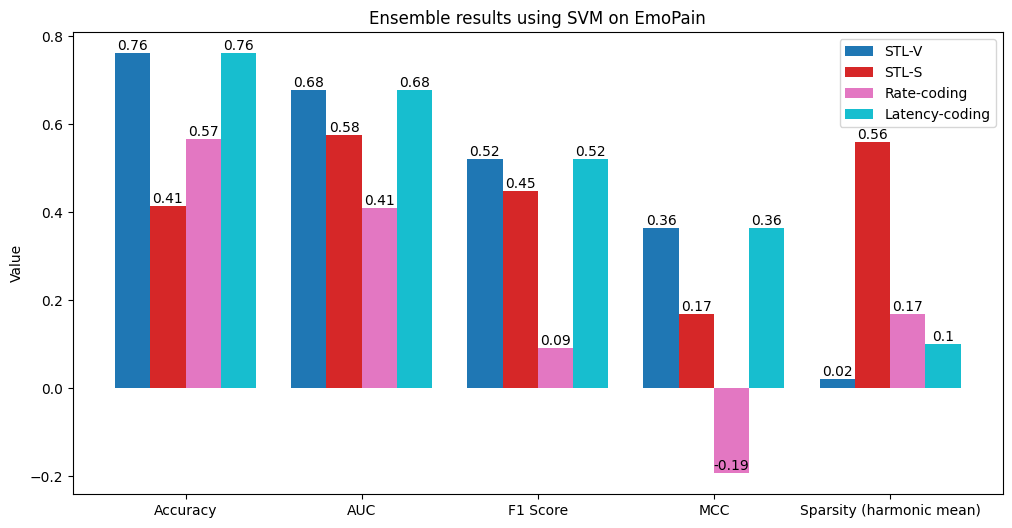

In [25]:
labels = list(ensemble.keys())
values = np.array(list(ensemble.values()))

x = np.arange(values.shape[1])
width = 0.2

colors = plt.cm.tab10(np.linspace(0, 1, len(ensemble)))

fig, ax = plt.subplots(figsize=(12, 6))

for i, (key, values) in enumerate(ensemble.items()):
    if key == "rate": key = "Rate-coding"
    if key == "latency": key = "Latency-coding"
    bars = ax.bar(x + i * width, values, width, label=key, color=colors[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), 
                va='bottom', ha='center')

ax.set_ylabel('Value')
ax.set_title('Ensemble results using SVM on EmoPain')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(["Accuracy", "AUC", "F1 Score", "MCC", "Sparsity (harmonic mean)"])
ax.legend()

plt.show()
